### Sample Exercise - Predict outcome (Won/Lost) of a given opportunity

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
import findspark
findspark.init()
import pyspark as ps

In [3]:
givenData = pd.read_csv('Exercise_Data.csv')
print givenData.describe()
print givenData.shape

       opportunity_key  introduction    diligence     proposal  negotiation  \
count     4.745000e+03    4745.00000  4745.000000  4745.000000  4745.000000   
mean      8.041308e+10      11.63393    74.909589    17.170285    11.099262   
std       3.658888e+10      52.83086   123.203228    65.127208    54.058335   
min       9.914004e+07       0.00000     0.000000     0.000000     0.000000   
25%       9.914004e+10       0.00000     0.000000     0.000000     0.000000   
50%       9.914004e+10       0.00000     0.000000     0.000000     0.000000   
75%       9.914004e+10       0.00000   109.000000     0.000000     0.000000   
max       9.914005e+10     663.00000   716.000000   633.000000   719.000000   

           closing  sos_opprtnty_est_value  
count  4745.000000            4.745000e+03  
mean      4.157218            2.494298e+04  
std      25.772724            2.755182e+05  
min       0.000000            0.000000e+00  
25%       0.000000            0.000000e+00  
50%       0.000000

In [5]:
#num of records - 4745
# no. of Won records - 1335 (28.13%)
# no. of Lost records - 3410 (71.87%)
# no. of records with 0.0 for every stage - 1525 (526 Won, 999 Lost) (32%)
# no. of industries - 42

# if (filtered) , records = 3220
# won = 809
# lost = 2411
len(givenData[(givenData['introduction'] == 0.0) & 
              (givenData['diligence'] == 0.0) &
              (givenData['proposal'] == 0.0) &
              (givenData['negotiation'] == 0.0) &
              (givenData['closing'] == 0.0) &
              (givenData['sos_opprtnty_est_value'] == 0.0)])
len(givenData[(givenData['sos_opprtnty_est_value'] == 0.0)])

2245

In [6]:
#Number of oppts won and lost, as viewed per industry type
lost = givenData[(givenData['final_status'] == 'Lost')].groupby(['org_industry_name'])['final_status'].count()
won = givenData[(givenData['final_status'] == 'Won')].groupby(['org_industry_name'])['final_status'].count()
lost_won = pd.concat([lost, won], axis = 1, keys = ['Lost', 'Won'])
lost_won = lost_won.fillna(0)
lost_won['won%'] = lost_won['Won']/(lost_won['Lost'] + lost_won['Won'])
print lost_won

                                Lost    Won      won%
Agency                           106   84.0  0.442105
Agriculture                        1    0.0  0.000000
Apparel                          186   90.0  0.326087
Automotive                        40   26.0  0.393939
Banking                           80   31.0  0.279279
Beauty & Fitness                  33   18.0  0.352941
Biotechnology                     11   12.0  0.521739
Chemicals                         10    1.0  0.090909
Communications                    25   11.0  0.305556
Construction                      15    3.0  0.166667
Consulting                        73   48.0  0.396694
Education                         57   17.0  0.229730
Electronics                       62   21.0  0.253012
Energy                             6    7.0  0.538462
Engineering                        2    2.0  0.500000
Entertainment                     97   45.0  0.316901
Environmental                      2    0.0  0.000000
Finance                     

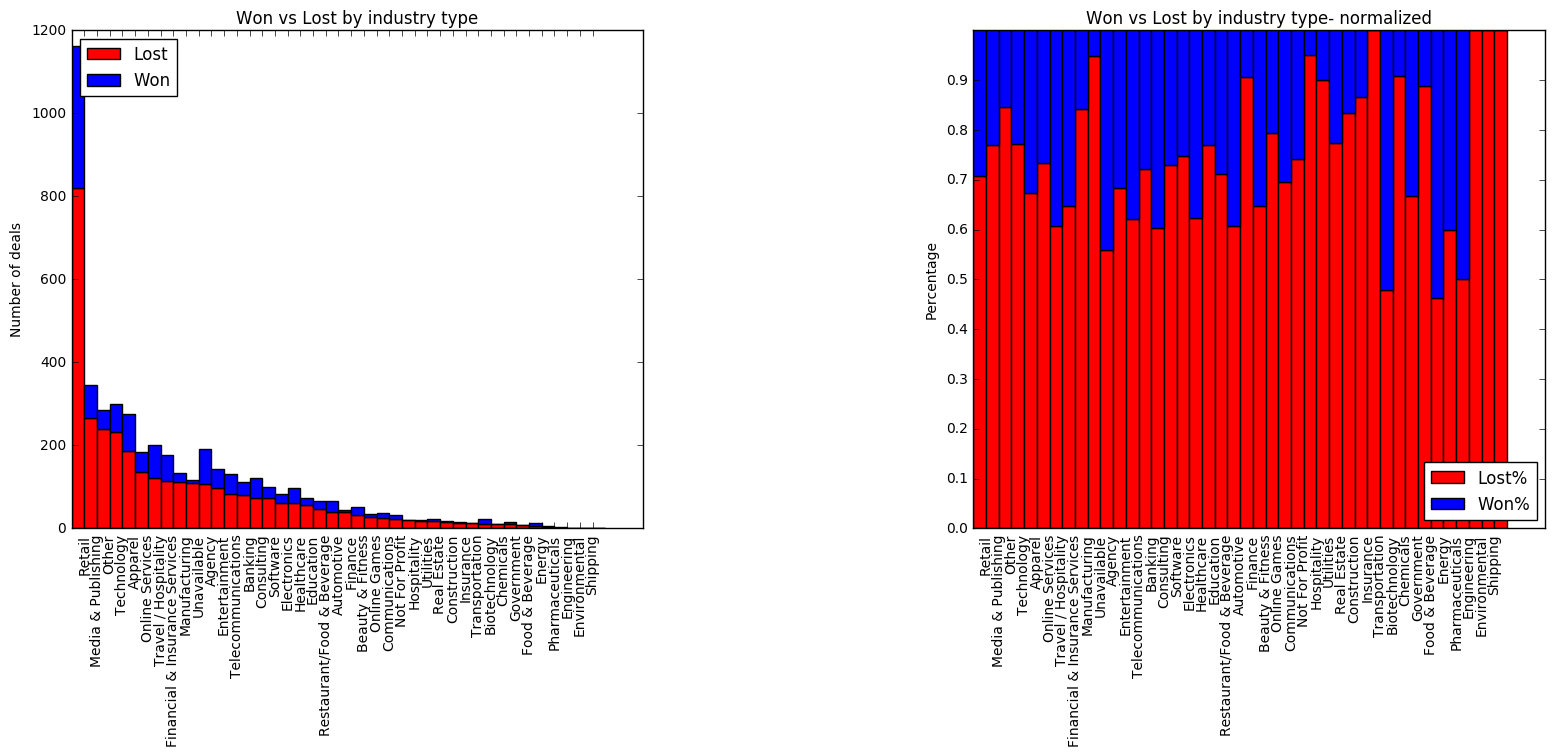

In [7]:
#visuals:
#1a. Analysis of Deals Won vs Lost for all Industry types 
#1b. Analysis of Deals Won vs Lost for all Industry types - normalized
lost_won.sort_values('Lost', ascending = False, inplace = True)

f, axarr = plt.subplots(1, 2)

lost = lost_won['Lost'].values
won = lost_won['Won'].values

wonPerc = lost_won['won%'].values
lostPerc = 1 - wonPerc

ind = np.arange(len(lost_won.index.values))
width = 1

p1 = axarr[0].bar(ind, lost, width, color='r')
p2 = axarr[0].bar(ind, won, width, color='b',bottom=lost)
p3 = axarr[1].bar(ind, lostPerc, width, color='r')
p4 = axarr[1].bar(ind, wonPerc, width, color='b',bottom=lostPerc)

axarr[0].set_ylabel('Number of deals')
axarr[0].set_title('Won vs Lost by industry type')
axarr[0].set_xticks(np.arange(1, len(ind),1))
axarr[0].set_xticklabels(lost_won.index.values, rotation = 'vertical')
#axarr[0].set_yticks(np.arange(0, max(won) + max(lost), 100))
axarr[0].legend((p1[0], p2[0]), ('Lost', 'Won'), loc = 'upper left')

axarr[1].set_ylabel('Percentage')
axarr[1].set_title('Won vs Lost by industry type- normalized')
axarr[1].set_xticks(np.arange(1, len(ind),1))
axarr[1].set_xticklabels(lost_won.index.values, rotation = 'vertical')
axarr[1].set_yticks(np.arange(0, 1.0, 0.1))
axarr[1].legend((p3[0], p4[0]), ('Lost%', 'Won%'), loc = 'lower right')

f.tight_layout(pad = 1)
f.set_figheight(15)
f.set_figwidth(20)
plt.show()

#Inference from plot:
#->quite a lot of industries have little data to conclude solid stats (approx last 10)
#->It would make sense to drop off the last 10 industries and look at the corresponding normalized chart
#->we observe that all industries (after filtering) have >50% lost deals
#->industry with highest probability of Win -> Agency
#->industry with lowest probability of Win -> Unavailable

In [8]:
#the est_value seems to have an extremely long tail; this could be a result of errorneous entry from a sales rep.
#so filtering in records for which estValue < 75,000
#Also, we can notice that there is a spike at est_value == 0.0; This could be due to a sales rep having
#missed out filling the detail. So we can filter those out for the sake of visulization. 
# i.e filter take records with est_values greater than 0 and less than equal to 75,000 

won_estValues = givenData[givenData['final_status'] == 'Won']['sos_opprtnty_est_value'].values #1335
lost_estValues = givenData[givenData['final_status'] == 'Lost']['sos_opprtnty_est_value'].values #3410

#number of won deals with est_value == 0.0 -> 541/1335
#number of lost deals with est_value == 0.0 -> 1704/3410
#total deals with est_values == 0.0 -> 2245/4745
#number of wont deals with est_value > 75000 -> 64/1335
#number of lost deals with est_value > 75000 -> 152/3410
#number of deals with est_value > 75000 -> 216/4745
#number of filtered records -> 2284/4745

won_estValues_filtered = won_estValues[(won_estValues > 0) & (won_estValues <= 75000)]
lost_estValues_filtered = lost_estValues[(lost_estValues > 0) & (lost_estValues <= 75000)]

1335
3410
730
1554


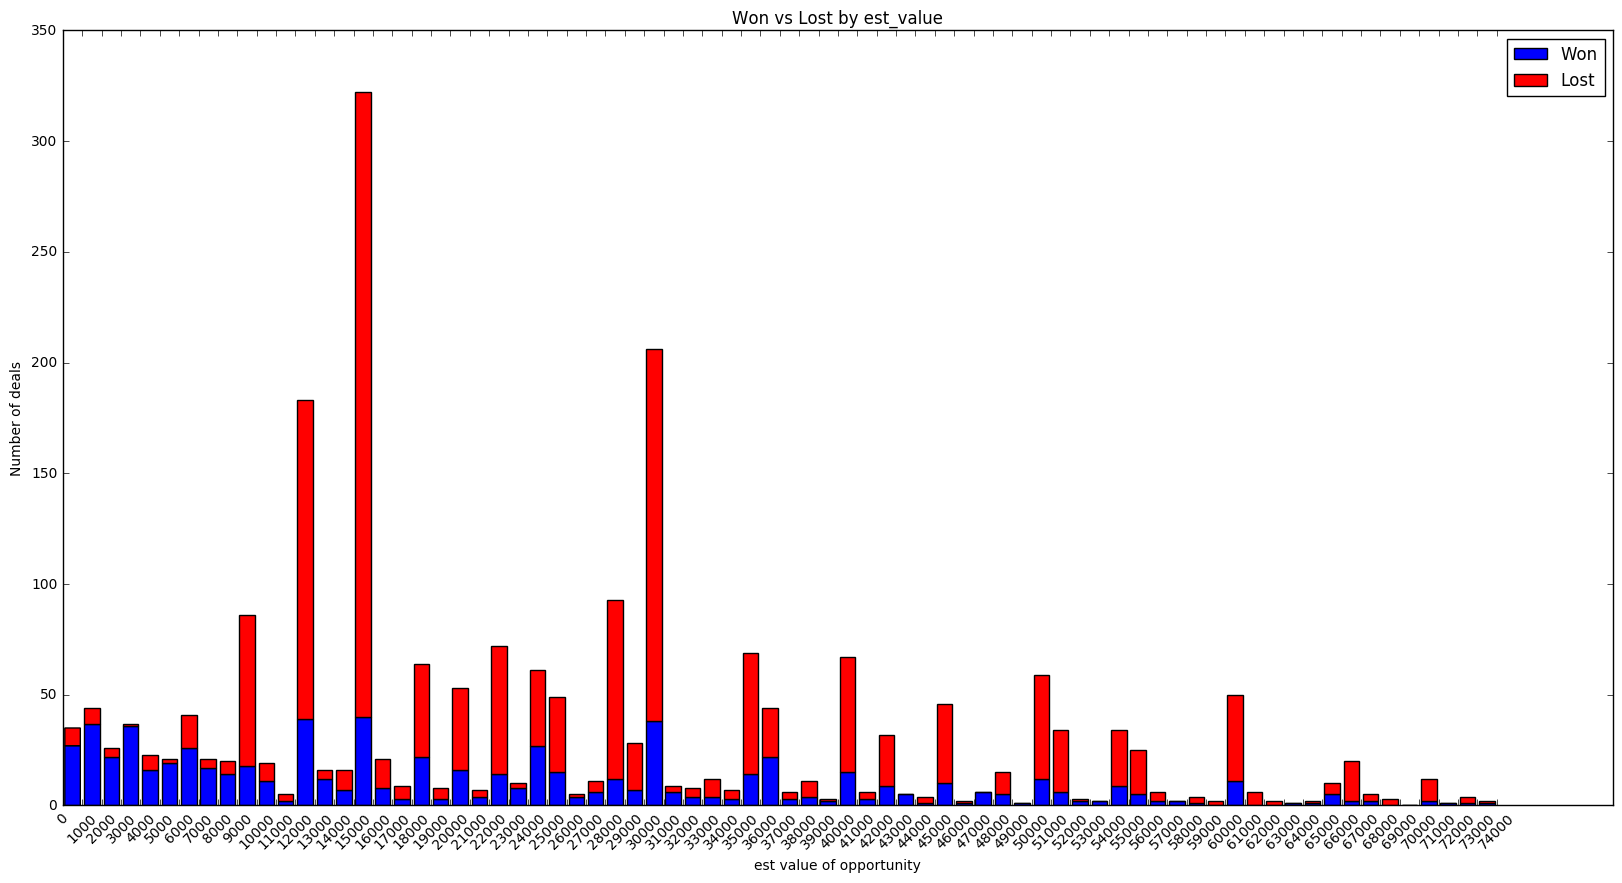

In [9]:
#2. Analysis of Oppts Won vs Lost for binned est_value
bins = range(0,75000,1000)
plt.figure(figsize=(20,10))
plt.hist([won_estValues_filtered, lost_estValues_filtered], bins, histtype='bar', stacked=True, color=['b', 'r'])
plt.title('Won vs Lost by est_value')
plt.ylabel('Number of deals')
plt.xlabel('est value of opportunity')
plt.xticks(np.arange(0, 75000,1000), rotation = 45)
plt.legend(('Won', 'Lost'), loc = 'upper right')
plt.show()
#Inference from the plot:
# ->3 spikes of losses visible for est_values in the bracket of approximately [12,500, 16,000 and 31,000]

In [10]:
# drop opportunity_key column
#and removing outliers/potentially erroneous data by filtering sos_opprtnty_est_value > 500,000 (just 5 records)
df = givenData[givenData['sos_opprtnty_est_value'] < 500000]
df = df.drop('opportunity_key', axis=1)
df.sort_values('sos_opprtnty_est_value', ascending = False)
d = {'Won':1, 'Lost':0}
df['final_status_num'] = df['final_status'].map(lambda x: d[x])
df

,introduction,diligence,proposal,negotiation,closing,org_industry_name,sos_opprtnty_est_value,final_status,final_status_num
0,0.0,0.0,0.0,0.0,0.0,Unavailable,1800.0,Won,1
1,0.0,0.0,0.0,0.0,0.0,Travel / Hospitality,6400.0,Won,1
2,0.0,0.0,0.0,0.0,0.0,Other,36000.0,Won,1
3,0.0,0.0,0.0,0.0,0.0,Consulting,4000.0,Won,1
4,0.0,0.0,0.0,0.0,0.0,Online Services,36000.0,Won,1
5,0.0,0.0,0.0,0.0,0.0,Apparel,27000.0,Won,1
6,0.0,0.0,0.0,0.0,0.0,Technology,120000.0,Lost,0
7,0.0,0.0,0.0,0.0,0.0,Banking,70000.0,Lost,0
8,0.0,0.0,0.0,0.0,0.0,Unavailable,120000.0,Lost,0
9,0.0,0.0,0.0,0.0,0.0,Technology,50000.0,Lost,0


In [11]:
from sklearn.preprocessing import LabelEncoder
#steps:

#EDIT: 'randomize' in these variables is a misnomer. I don't randomize for the visualization analysis
df_random = df[df['final_status_num'] >= 0]
df_random_normalized = df_random[df_random['final_status_num'] >= 0]

#1. normalize number of days spent in each stage 
#   normalizing with x - mean(stage)/ max(stage) - min(stage)
cols_to_norm = ['introduction', 'diligence', 'proposal', 'negotiation', 'closing', 'sos_opprtnty_est_value']
df_random_normalized[cols_to_norm] = df_random_normalized[cols_to_norm].apply(lambda x: (x - x.mean()) / (x.max() - x.min()))

#2. getDummies for org_industry_name
org_industry_name = df_random_normalized['org_industry_name']
df_random_processed = df_random_normalized[df_random_normalized['final_status_num'] >=0]
df_random_processed = pd.get_dummies(df_random_processed.iloc[:,:-2])

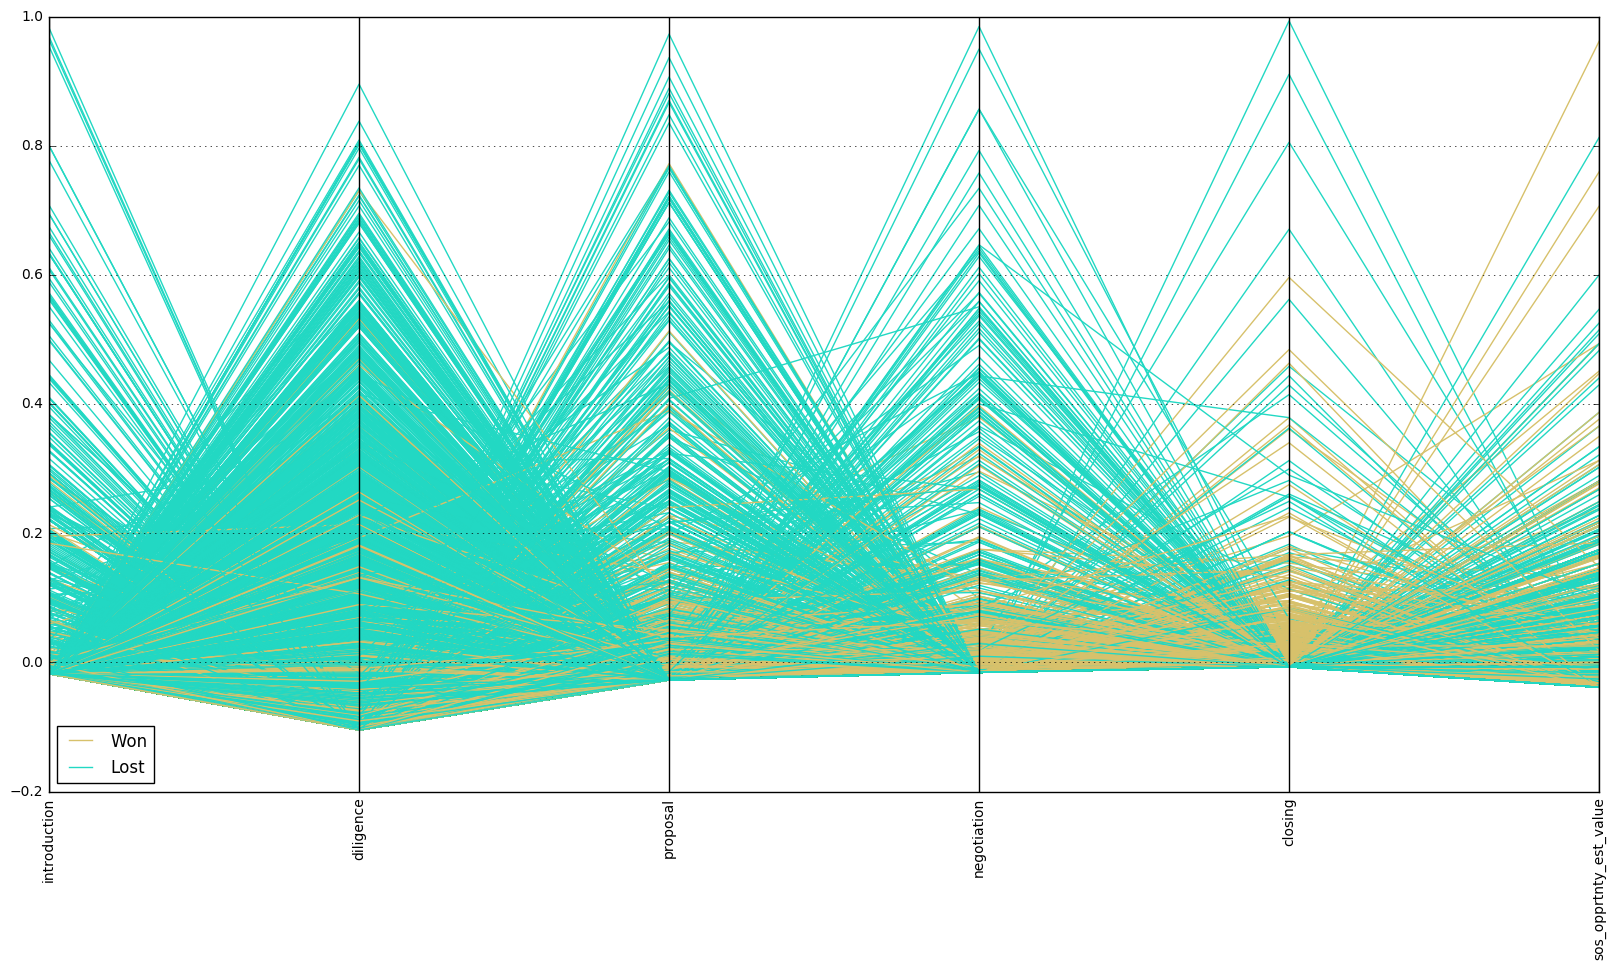

In [12]:
#3. parallel coordinates
from pandas.tools.plotting import parallel_coordinates

le = LabelEncoder()
le = le.fit(org_industry_name)

df_random_processed_converted = df_random_normalized[df_random_normalized['final_status'] >= 0]
df_random_processed_converted.org_industry_name = le.fit_transform(df_random_processed_converted.org_industry_name)

cols_to_norm = ['org_industry_name']
df_random_processed_converted['org_normalized'] = df_random_processed_converted[cols_to_norm].apply(lambda x: (x - x.mean()) / (x.max() - x.min()))

#parallel coordinates
plt.figure(figsize=(20,10))
plt.xticks(rotation = 'vertical')
parallel_coordinates(df_random_processed_converted.drop(['org_industry_name', 'org_normalized', 'final_status_num'], axis=1), 'final_status')
plt.legend(loc = 'lower left')
plt.show()
#inference:
#-> The plot shows a clumping of Won opportunities around the 'Closing' column. Look like if the 'Closing is between x
#   and y days, it would be a strong indicator of a Won Opportunity.
#-> Most of theLost opportunities spend a relatively smaller portion of time in the closig stage
#-> Beyond 'x' days in any stage, the probability of a given opportunity to be Lost is much higher as compared that 
#   of it being Won

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1160004d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1171d4390>]], dtype=object)

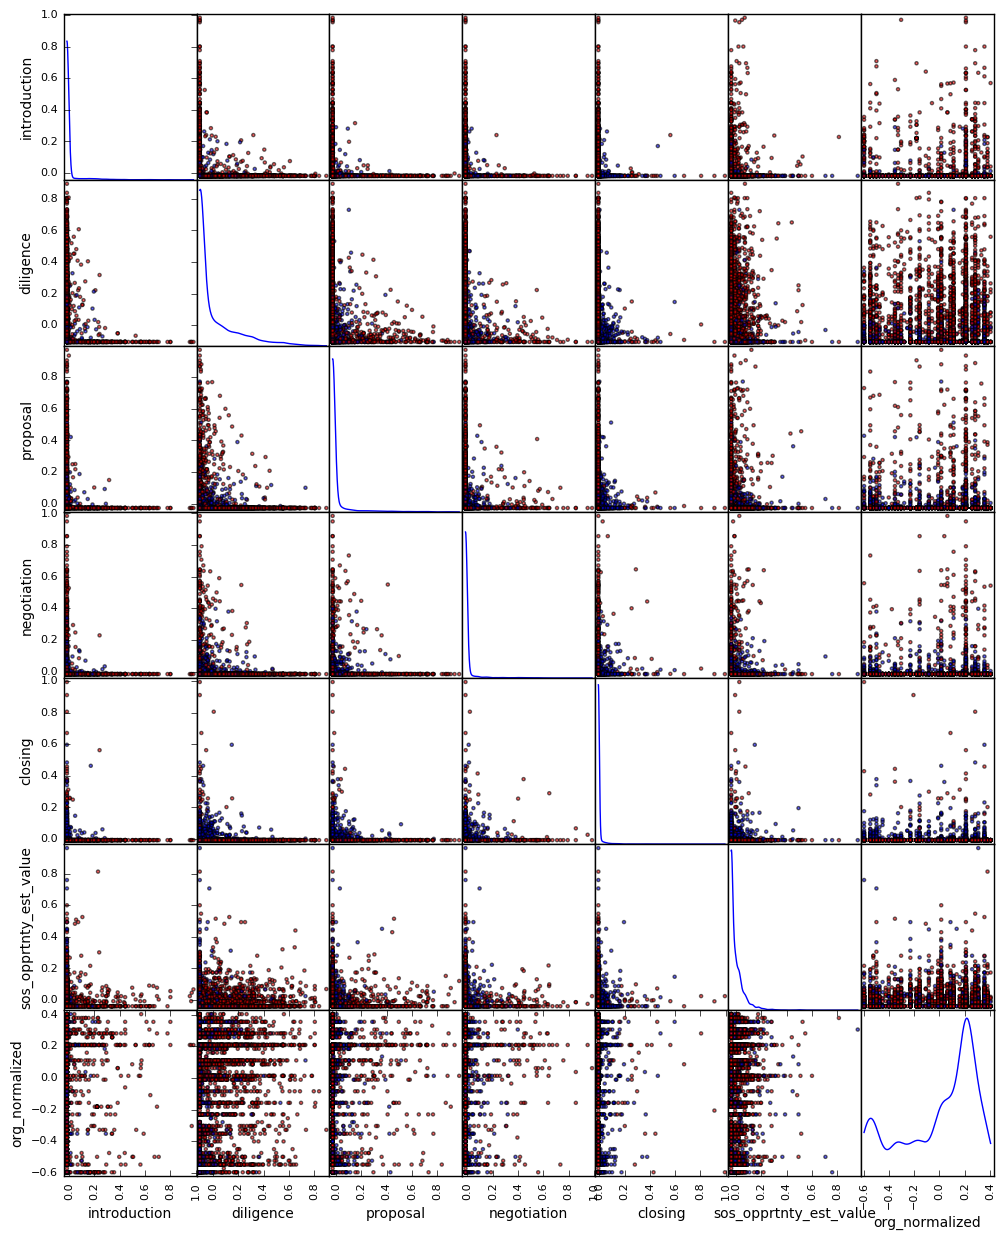

In [15]:
#4. Scatter plots of [Intro, Diligence, Proposal, negotiation, closing, industry_name, est_value] 
from pandas.tools.plotting import scatter_matrix
colors = ['red', 'blue']
df_for_Scatter = df_random_processed_converted.drop(['final_status','org_industry_name'], axis=1)
scatter_matrix(df_for_Scatter.drop('final_status_num', axis =1), alpha = 0.6, figsize = [12, 15], c=df_for_Scatter.final_status_num.apply(lambda x: colors[x]), diagonal = 'kde')
#Inference:
# The plots for 'closing' look most interesting. In those plots, a very good distiction between Won and Lost opportunities can be seen

In [23]:
#Steps:
#I. Data preparation
#II. Model Selection
#III. Model Training
#IV. Performance Evaluation

#global-variables
maxim = {}; minim = {}; mean = {}; org_industry_names = {}

# Feature-engineering: new feature addition
#based on analysis, 
#replicating the 'closing' column as this seems to be a prime feature which allows separability of the classes
#By doing this, there was an approimate gain of 2-5% in the performance across all classifiers

givenData['closing2'] = givenData['closing']

In [24]:
#I. Data preparation

#Steps
#1. Randomize given data
#2. Do a 60-20-20 split (60-20 forms the cross validation set, 20 forms the test set; remove the test set)
#3. Write a function 'process' to transform and filter dataset, so we can train on it. The functtion should do the following:
    #pre. filter outlier/erroneous data (done only for training)
    #a. drop irrelevant columns
    #b. normalize columns for stages and est_value
    #c. get_dummies for org_name
    # Note: The function behaviour should be different for train and test
    #       For train set, it should calculate values of mean, min and max from the data already present. 
    #       For test, it should use pre-calculated data from train set
    
#1
givenData_random  = givenData.reindex(np.random.permutation(givenData.index))

#2
splitAt = int(0.2 * len(givenData_random))
test = givenData_random[0:splitAt]
cv_trainTest = givenData_random[splitAt:] 

#3
def process(input_df, isTest = False):
    global org_industry_names, minim, maxim, mean

    if (isTest):
        #a - drop redundant columns
        res_df = input_df.drop('opportunity_key', axis=1)
    else:    
        #pre - filters outliers in est_value
        res_df = input_df[input_df['sos_opprtnty_est_value'] < 500000]
        #a - drop redundant columns
        res_df = res_df.drop('opportunity_key', axis=1)
    
    
    #b - normalize columns
    cols_to_norm = ['introduction', 'diligence', 'proposal', 'negotiation', 'closing', 'closing2', 'sos_opprtnty_est_value']
    for c in cols_to_norm:
        if(not isTest):
            maxim[c] = res_df[c].max()
            minim[c] = res_df[c].min()
            mean[c] = res_df[c].mean()
        res_df[c] = (res_df[c] - mean[c]) / (maxim[c] + minim[c])
    
    
    #c - Transform the final_status to numerical
    d = {'Won':1, 'Lost':-1}
    res_df['final_status'] = res_df['final_status'].map(lambda x: d[x])
    
    #d - get dummies for org_industry_name
    if (not isTest):
        org_industry_names = {k for k in res_df['org_industry_name'].values}
        res_df = pd.get_dummies(res_df)
    else:
        org_names_test = set(res_df['org_industry_name'].values)
        tstOnly_orgNames = org_names_test - org_industry_names
        trainOnly_orgNames = org_industry_names - org_names_test
        res_df = pd.get_dummies(res_df)
        for n in trainOnly_orgNames:
            res_df['org_industry_name_'+n] = 0
        
        for n in tstOnly_orgNames:
            res_df = res_df.drop('org_industry_name_'+n , axis = 1)

    features =  [col for col in res_df.columns if col != 'final_status']
    return res_df[features], res_df['final_status']



In [25]:
#5. TSNE visualization
# from sklearn.manifold import TSNE
# tr = givenData_random[givenData_random['sos_opprtnty_est_value'] < 500000]
# y = tr['final_status']
# cols = tr.columns.drop(['final_status', 'opportunity_key', 'closing2'])
# x = tr[cols]
# x.org_industry_name = le.fit_transform(x.org_industry_name)
# X_tsne = TSNE().fit_transform(x)
# y_num = y.apply(lambda x: d[x]).values
# plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c = y_num)

In [28]:
#II. Model Selection

#Steps
#1. import various classifier models that need to be tried out
#2. Do 5-fold cross validation on the CV set and get the top 5 performing models
#3. For each fold in the CV, use grid search for selecting the best parameters intially

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

import xgboost as xgb

#Logistic Regression
lr = LogisticRegression(penalty='l2', random_state = 10, C = 45)
Cs = np.logspace(-5, 5, 10)
clf_logisticRegression = GridSearchCV(estimator = lr, 
                                      param_grid = dict(),
                                      #param_grid = dict(C= Cs),
                                      n_jobs = -1)

clf_svmLinear = SVC(C=1.0, kernel = 'linear', probability=True)
clf_svmPoly = SVC(C=1.0, degree = 5, kernel = 'poly', probability=True)
clf_svmRbf = SVC(C=1.0, gamma = 1.0)

num_trees = range(50, 700, 150); n_feats = range(4,11,2); max_depths = range(1,7); learn_rates = np.logspace(-5,1,10)
#RF
rf = RandomForestClassifier(n_estimators=100, max_features=9)
clf_randomForest = GridSearchCV(estimator = rf, 
                                param_grid = dict(),
                                #param_grid = dict(n_estimators = num_trees, max_feature = n_feats),
                                n_jobs = -1)

extraTrees = ExtraTreesClassifier(n_estimators = 550, max_features = 9)
clf_extraTrees = GridSearchCV(estimator = extraTrees, 
                                param_grid = dict(),
                                #param_grid = dict(n_estimators = [100, 250, 400, 550, 650, 600], max_features = range(1,10,2)),
                                n_jobs = -1)

ada_boost = AdaBoostClassifier(n_estimators = 650, learning_rate = 0.1)
clf_adaBoost = GridSearchCV(estimator = ada_boost, 
                                #param_grid = dict(n_estimators = [100, 250, 400, 550, 650, 600], learning_rate = learn_rates),
                                param_grid = dict(),
                                n_jobs = -1)
#clf_adaBoost = AdaBoostClassifier(n_estimators=100)

gb = GradientBoostingClassifier(n_estimators = 400,
                                max_depth = 3,
                                max_features = 8,
                                learning_rate = 0.1)
clf_gb = GridSearchCV(estimator = gb, 
                      param_grid = dict(), 
                      #param_grid = dict(n_estimators = num_trees, max_features = n_feats, learning_rate = learn_rates), 
                      n_jobs = -1)

#clf_xgb = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05)

#clfs = [clf_adaBoost]
#clf_names = ['adaBoost']

clfs = [clf_logisticRegression, clf_randomForest, clf_extraTrees, clf_adaBoost, clf_gb]
clf_names = ['LR','random_forest', 'extra_trees', 'ada_boost', 'gbm']

X_Y = cv_trainTest


In [29]:
from sklearn.metrics import accuracy_score

kf = KFold(n_splits=5, shuffle = True)
kf.get_n_splits(X_Y)
max = 0
scores = []

def getSortKey(item):
    return item[0]

for idx in range(0,len(clfs)):
    #implement cross-validation    
    cv_scores = []
    for train_index, test_index in kf.split(X_Y):
        X_train, Y_train = process(X_Y.iloc[train_index])
        X_test, Y_test = process(X_Y.iloc[test_index], True)
        clf = clfs[idx].fit(X_train, Y_train)
        #print 'best params %s' %(clf.best_params_)
        score = clf.score(X_test, Y_test)
        cv_scores.append(score)
        
    scores.append(np.mean(cv_scores))

clf_composite = zip(scores, clfs, clf_names)    
clf_composite_sorted = sorted(clf_composite, key = getSortKey, reverse=True)
clfs_top5 = clf_composite_sorted[0:5]
print(clfs_top5[0][0],clfs_top5[0][2])    
#inference -> adaBoost/gbm classifier seems to be doing the best

(0.83693190486096669, 'ada_boost')


In [33]:
#III. Model Training
X_train, Y_train = process(X_Y)
models = [c.fit(X_train, Y_train) for c in [x[1] for x in clfs_top5]] 

In [42]:
#IV. Performance Evaluation
from sklearn.model_selection import cross_val_score

X_test, Y_test = process(test, True)
#scores = [model.score(X_test, Y_test) for model in models]
scores = [model.score(X_test, Y_test) for model in models]
accuracies = [cross_val_score(model, X_test, Y_test, scoring='accuracy') for model in models]
precisions = [cross_val_score(model, X_test, Y_test, scoring='precision') for model in models]
recalls = [cross_val_score(model, X_test, Y_test, scoring='recall') for model in models]
f1s =[cross_val_score(model, X_test, Y_test, scoring='f1') for model in models]

[(0.86301369863013699, 'ada_boost'),
 (0.83561643835616439, 'random_forest'),
 (0.86512118018967332, 'gbm'),
 (0.82191780821917804, 'extra_trees'),
 (0.75342465753424659, 'LR')]

In [46]:
#scores - default
print 'Default score'
print zip(scores, [c[2] for c in clfs_top5])
print
print 'Accuracy'
print zip(accuracies, [c[2] for c in clfs_top5])
print
print 'Precision'
print zip(precisions, [c[2] for c in clfs_top5])
print
print 'Recall'
print zip(recalls, [c[2] for c in clfs_top5])
print
print 'F1' 
print zip(f1s, [c[2] for c in clfs_top5])

Default score
[(0.86301369863013699, 'ada_boost'), (0.83561643835616439, 'random_forest'), (0.86512118018967332, 'gbm'), (0.82191780821917804, 'extra_trees'), (0.75342465753424659, 'LR')]

Accuracy
[(array([ 0.85173502,  0.84810127,  0.83544304]), 'ada_boost'), (array([ 0.88328076,  0.84177215,  0.83227848]), 'random_forest'), (array([ 0.85173502,  0.83227848,  0.84177215]), 'gbm'), (array([ 0.84858044,  0.81329114,  0.7943038 ]), 'extra_trees'), (array([ 0.77287066,  0.74367089,  0.75949367]), 'LR')]

Precision
[(array([ 0.86046512,  0.78846154,  0.80952381]), 'ada_boost'), (array([ 0.79104478,  0.70833333,  0.76363636]), 'random_forest'), (array([ 0.73015873,  0.66666667,  0.76595745]), 'gbm'), (array([ 0.74242424,  0.625     ,  0.59322034]), 'extra_trees'), (array([ 0.63636364,  0.45714286,  0.53571429]), 'LR')]

Recall
[(array([ 0.47435897,  0.52564103,  0.43589744]), 'ada_boost'), (array([ 0.66666667,  0.61538462,  0.51282051]), 'random_forest'), (array([ 0.61538462,  0.61538462, 

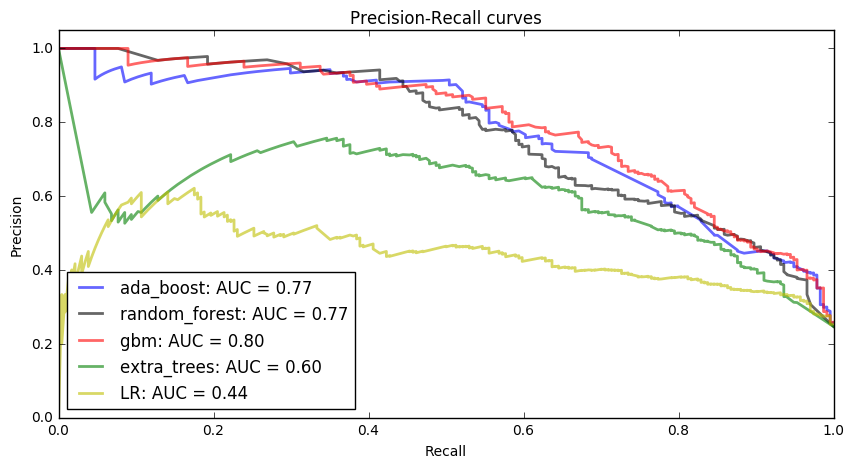

In [36]:
# #PR curves
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

colors = ['b', 'k', 'r', 'g', 'y']

Y_scores = [model.fit(X_train, Y_train).predict_proba(X_test)[:,1] for model in models]
precision = dict()
recall = dict()
average_precision = dict()

plt.clf()
plt.figure(figsize=(10,5))
for idx, Y_score in enumerate(Y_scores):
    precision, recall, _ = precision_recall_curve(Y_test,Y_score)
    average_precision = average_precision_score(Y_test.ravel(), Y_score.ravel())

    #Plot Precision-Recall curve
    lbl = '%s: AUC = %0.2f' %(clfs_top5[idx][2], average_precision)
    plt.plot(recall, precision, lw=2, color=colors[idx], label=lbl, alpha = 0.6)
    
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curves')
plt.legend(loc="lower left")
plt.show()

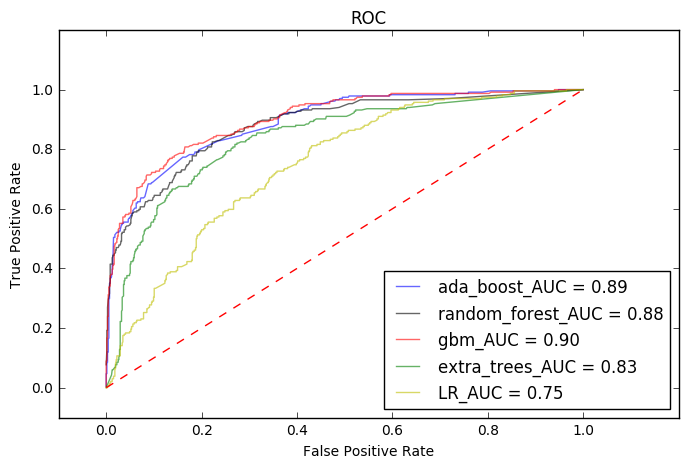

In [38]:
#ROC curves
from sklearn.metrics import roc_curve, auc

predictions_all = [model.predict_proba(X_test)[:,1] for model in models]

plt.figure(figsize=(8,5))
plt.title('ROC')    
for idx,predictions in enumerate(predictions_all):
    false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, predictions)
    roc_auc = auc(false_positive_rate, true_positive_rate)    
    lbl = clfs_top5[idx][2]+'_AUC = %0.2f' % roc_auc
    plt.plot(false_positive_rate, true_positive_rate, colors[idx], label=lbl, alpha = 0.6)

plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [40]:
# Some other things I couldn't get to:
#1. platt scaling for threshold calibration
#2. try out vowpal wabbit & xgboost (xgBoost had issues with column ordering)